<a href="https://colab.research.google.com/github/viksit-siddhant/Variatonal-Autoencoder/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras import layers
import numpy as np
import tensorflow as tf

class Sampler(layers.Layer):

    def call(self, inputs):
        z_mean, z_var = inputs
        return z_mean + tf.exp(z_var)*tf.keras.backend.random_normal(shape=tf.shape(z_mean))

In [ ]:
enc_input = keras.layers.Input((28,28,1))

x = keras.layers.Conv2D(32,3,strides=2,padding='same',activation='relu')(enc_input)
x = keras.layers.Conv2D(64,3,strides=2,padding='same',activation='relu')(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(16, activation = 'relu')(x)

z_mean = keras.layers.Dense(3)(x)
z_var = keras.layers.Dense(3)(x)

z = Sampler()([z_mean,z_var])

encoder = keras.Model(enc_input,[z_mean,z_var,z])
encoder.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 32)   320         ['input_11[0][0]']               
                                                                                                  
 conv2d_13 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_12[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 3136)         0           ['conv2d_13[0][0]']              
                                                                                            

In [ ]:
dec_inc = keras.layers.Input(shape=(3))
x = keras.layers.Dense(7*7*64)(dec_inc)
x = keras.layers.Reshape((7,7,64))(x)

x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(dec_inc, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 3)]               0         
                                                                 
 dense_18 (Dense)            (None, 3136)              12544     
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_9 (Conv2DT  (None, 14, 14, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_10 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 28, 28, 1)        289 

In [ ]:
class model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(model,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss = keras.metrics.Mean(name='total')
        self.recon_loss = keras.metrics.Mean(name='recon')
        self.kl_loss = keras.metrics.Mean(name='KL')

    @property
    def metrics(self):
        return [self.total_loss,self.recon_loss,self.kl_loss]
    

    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z = self.encoder(data)
            recon = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data,recon),axis=(1,2)))
            kl_loss = tf.square(z_mean) + tf.exp(z_log_var) - 1 - z_log_var
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss,axis=1))
            total_loss = recon_loss + kl_loss
            grads = tape.gradient(total_loss,self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
            self.total_loss.update_state(total_loss)
            self.recon_loss.update_state(recon_loss)
            self.kl_loss.update_state(kl_loss)
            return {
            "loss": self.total_loss.result(),
            "reconstruction_loss": self.recon_loss.result(),
            "kl_loss": self.kl_loss.result(),
            }
    

In [ ]:
(x_train,y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = model(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128) 

Epoch 1/30
547/547 [==============================] - 6s 9ms/step - loss: 252.7129 - reconstruction_loss: 248.7973 - kl_loss: 3.9156
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 190.1078 - reconstruction_loss: 187.0048 - kl_loss: 3.1031
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 180.0762 - reconstruction_loss: 176.0700 - kl_loss: 4.0063
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 155.7760 - reconstruction_loss: 148.3404 - kl_loss: 7.4356
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - loss: 149.2558 - reconstruction_loss: 141.3951 - kl_loss: 7.8606
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 146.7624 - reconstruction_loss: 138.8403 - kl_loss: 7.9222
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 145.1130 - reconstruction_loss: 137.1640 - kl_loss: 7.9490
Epoch 8/30
547/547 [==============================] - 5s 9ms/step - l

[[ 0.5917537  -1.0304397   0.52944475]]


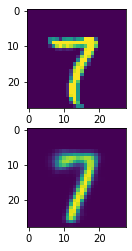

In [ ]:
import matplotlib.pyplot as plt

rand_im = mnist_digits[np.random.randint(0,60000-1)]
#print(rand_im.shape)

fig, (orig, decoded) = plt.subplots(2)

orig.imshow(rand_im.reshape((28,28)))
_,_,z = vae.encoder.predict(rand_im.reshape([1,28,28,1]))
print(z)
#z = np.array([[0.21082003,0.06122002]])
decoded.imshow(vae.decoder.predict(z).reshape((28,28)))

plt.show()